# Bands Structure
For the source code, see [bands](https://workgraph-collections.readthedocs.io/en/latest/qe/module.html#workgraph_collections.ase.espresso.bands.bands_workgraph).


## Example: Silicon band structure
### Prepare the inputs and visualize the WorkGraph



In [1]:
from copy import deepcopy
from aiida import load_profile
from aiida.orm import Dict, KpointsData, StructureData, load_code
from ase.build import bulk
from workgraph_collections.qe.bands import BandsWorkgraph

load_profile()

atoms = bulk('Si')
structure_si = StructureData(ase=atoms)

pw_code = load_code('pw-7.4@localhost')
scf_paras = {
    'CONTROL': {
        'calculation': 'scf',
    },
    'SYSTEM': {
        'ecutwfc': 30,
        'ecutrho': 240,
        'occupations': 'smearing',
        'smearing': 'gaussian',
        'degauss': 0.1,
    },
}
relax_paras = deepcopy(scf_paras)
relax_paras['CONTROL']['calculation'] = 'vc-relax'
bands_paras = deepcopy(scf_paras)
bands_paras['CONTROL']['calculation'] = 'bands'

kpoints = KpointsData()
kpoints.set_kpoints_mesh([3, 3, 3])
#
metadata = {
    'options': {
        'resources': {
            'num_machines': 1,
            'num_mpiprocs_per_machine': 4,
        },
    }
}

bands_inputs = {
    'relax': {
        'base': {
            'pw': {
                'parameters': Dict(relax_paras),
                'metadata': metadata,
            },
            'kpoints': kpoints,
        },
    },
    'scf': {
        'pw': {
            'parameters': Dict(scf_paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
    'bands': {
        'pw': {
            'parameters': Dict(bands_paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
}

wg = BandsWorkgraph.build_graph(
    structure=structure_si,
    code=pw_code,
    inputs=bands_inputs,
    pseudo_family='SSSP/1.3/PBEsol/efficiency',
    run_relax=True,
    bands_kpoints_distance=0.1,
)
wg.to_html()

## Run the WorkGraph

In [2]:
wg.run()

09/02/2025 01:00:02 PM <1272331> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175111|WorkGraphEngine|continue_workgraph]: tasks ready to run: PwRelaxWorkChain
09/02/2025 01:00:03 PM <1272331> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175111|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 175117
09/02/2025 01:00:09 PM <1272331> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175117|PwRelaxWorkChain|run_relax]: launching PwBaseWorkChain<175120>
09/02/2025 01:00:09 PM <1272331> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175120|PwBaseWorkChain|run_process]: launching PwCalculation<175123> iteration #1
09/02/2025 01:00:24 PM <1272331> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175120|PwBaseWorkChain|results]: work chain completed after 1 iterations
09/02/2025 01:00:24 PM <1272331> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175

## Plot the band structure

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='Dispersion (eV)'>)

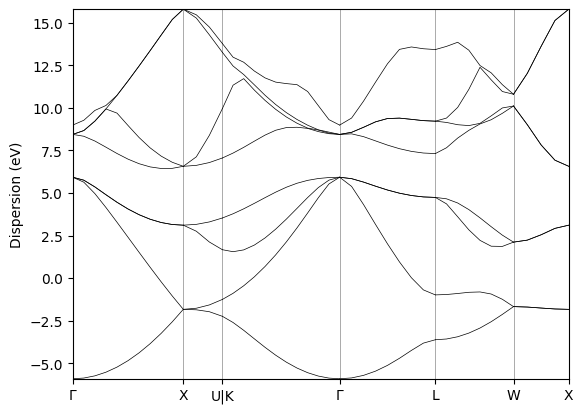

In [3]:
from workgraph_collections.qe.utils import plot_bandstructure
    
bands = wg.outputs.output_band.value
plot_bandstructure(bands)